### Data Analysis Pipeline

- **Create Simulation**: Represent Ancient and strong selection.
- **Leverage Pre-trained Model**: Use a model trained on recent and strong selection with high accuracy. Model can be considered fit for purpose if 80% accuracy and above
- **Training Regimen**:
  - Train for 9 epochs.
  - 1 epochs each from batches 1-9 of training data.
  - Test on the final batch of unseen data.
- **40k Simulations used**




In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training/Ancient_strong

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 5214, done.
remote: Counting objects: 100% (835/835), done.
remote: Compressing objects: 100% (584/584), done.
remote: Total 5214 (delta 307), reused 751 (delta 243), pack-reused 4379
Receiving objects: 100% (5214/5214), 7.23 GiB | 32.33 MiB/s, done.
Resolving deltas: 100% (1898/1898), done.
Updating files: 100% (140/140), done.
/content/EvoNet-CNN-Insight/model_training/Ancient_strong


In [12]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")


# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Run ImaGene.py

In [13]:
#%run -i ../../ImaGene.py
%run -i ImaGene.py

In [4]:
#run to make simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_Ancient_strong.txt".split());

 the first iteration of training.


In [14]:

path_sim = './'

In [15]:
file_sim = ImaFile(simulations_folder=path_sim + 'AS/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [16]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=100);

We can have a look at the data stored in this object.

In [17]:
gene_sim.summary();

An object of 200 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 223, max 440, mean 326.345000, std 44.542294


In [18]:
# Filter simulations based on frequency threshold of 0.01
gene_sim.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim.sort('rows_freq')

# Provide summary of the simulation data
gene_sim.summary()
# Resize simulation data to (198, 192)
gene_sim.resize((198, 192))

# Provide summary of the simulation data
gene_sim.summary()
# Convert simulation data with data augmentation (flip)
gene_sim.convert(flip=True)

# Provide summary of the simulation data
gene_sim.summary()


An object of 200 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 124, max 350, mean 238.670000, std 42.890804
An object of 200 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000
An object of 200 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

information on the corresponding targets (in this case the selection coefficient, either 0 or selection coefficient of choice in $2N_e$ units with $N_e = 10000$).

0


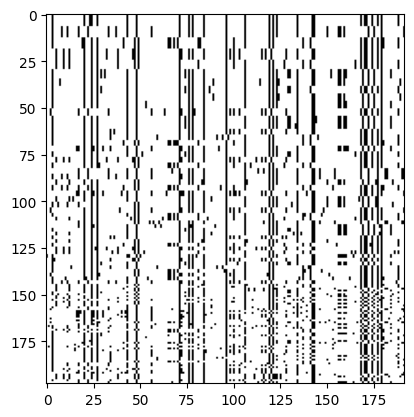

300


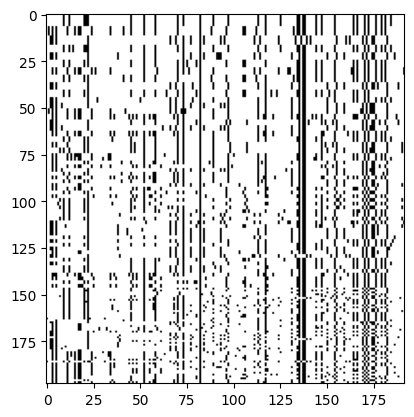

In [19]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [20]:
# Subset the simulation data with random indices
gene_sim.subset(get_index_random(gene_sim))

# Convert targets to binary format
gene_sim.targets = to_binary(gene_sim.targets)


In [25]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(198, 192, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

X_train, X_val, y_train, y_val = train_test_split(gene_sim.data, gene_sim.targets, test_size=0.2, random_state=42)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 198, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 198, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 198, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 99, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 99, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 99, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 49, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 49, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 49, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 49, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [14]:
score = model.fit(datagen.flow(X_train_rgb, y_train, batch_size=64),epochs=30, validation_data=(X_val_rgb, y_val))

Epoch 1/30


2024-08-01 18:07:05.660268: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1791', 492 bytes spill stores, 492 bytes spill loads

2024-08-01 18:07:05.765177: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1791', 436 bytes spill stores, 436 bytes spill loads



50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 522ms/step - accuracy: 0.5278 - loss: 0.7385 - val_accuracy: 0.6125 - val_loss: 0.6690
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.5583 - loss: 0.6891 - val_accuracy: 0.6413 - val_loss: 0.6340
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - accuracy: 0.6106 - loss: 0.6537 - val_accuracy: 0.6175 - val_loss: 0.6286
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.6432 - loss: 0.6302 - val_accuracy: 0.6463 - val_loss: 0.5993
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.6448 - loss: 0.6180 - val_accuracy: 0.6737 - val_loss: 0.5853
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.6865 - loss: 0.5889 - val_accuracy: 0.6600 - val_loss: 0.6023
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.6833 - loss: 0.5925 - val_accuracy: 0.6875 - val_loss: 0.5673
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - accuracy: 0.6993 - loss: 0.5902 - val_accuracy: 0.677

In [18]:
net_LCT = ImaNet(name='BaseModel_FineTuned_D128')


In [19]:
net_LCT.update_scores(score);

2
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 396ms/step - accuracy: 0.6909 - loss: 0.5667 - val_accuracy: 0.6812 - val_loss: 0.5980
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.7033 - loss: 0.5661 - val_accuracy: 0.7113 - val_loss: 0.5326
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.7101 - loss: 0.5626 - val_accuracy: 0.6662 - val_loss: 0.6002
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.6986 - loss: 0.5720 - val_accuracy: 0.6837 - val_loss: 0.5893
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.6996 - loss: 0.5648 - val_accuracy: 0.6775 - val_loss: 0.6031
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.7108 - loss: 0.5593 - val_accuracy: 0.7100 - val_loss: 0.5537
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.7086 - loss: 0.5584 - val_accuracy: 0.6600 - val_loss: 0.6374
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - accuracy: 0.6952 - loss: 0.5648 - val_ac

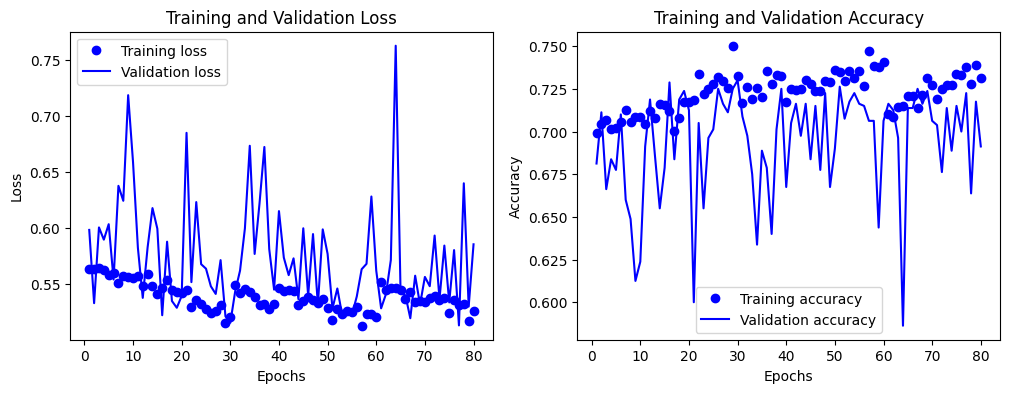

In [27]:
i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Loop to iterate through different simulation datasets
while i < 10:
    print(i)

    # Create ImaFile object for the specified simulation folder and model
    file_sim = ImaFile(simulations_folder=path_sim + 'AS/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # Read the simulation data
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    # Filter simulations based on frequency threshold
    gene_sim.filter_freq(0.01)

    # Sort simulations by row frequency
    gene_sim.sort('rows_freq')

    # Resize simulation data to the required dimensions
    gene_sim.resize((198, 192))

    # Convert simulation data (flip=True allows for data augmentation)
    gene_sim.convert(flip=True)

    # Get a random subset of indices and subset the simulation data
    gene_sim.subset(get_index_random(gene_sim))

    # Convert targets to binary format
    gene_sim.targets = to_binary(gene_sim.targets)

    # Train the model on the current subset of simulation data
    X_train, X_val, y_train, y_val = train_test_split(gene_sim.data, gene_sim.targets, test_size=0.2, random_state=seed)
    X_train_rgb = np.repeat(X_train, 3, axis=-1)
    X_val_rgb = np.repeat(X_val, 3, axis=-1)
    score = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=10, validation_data=(X_val_rgb, y_val))

    # Update scores with the current training results
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    # Increment the index for the next iteration
    i += 1

# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Create a figure for plotting
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, all_scores['loss'], 'bo', label='Training loss')
plt.plot(epochs, all_scores['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, all_scores['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, all_scores['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()

Evaluate the training on the testing dataset, Which is the last batch of the the 10th simulation in the file
The log the testing validation and loss alongside the F1,

In [28]:
# Set the simulation index
i = 10

# Create an ImaFile object for the specified simulation folder and model
file_sim = ImaFile(simulations_folder=path_sim + 'AS/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data with the specified parameter and maximum number of replicates
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

# Filter the simulations based on a frequency threshold of 0.01
gene_sim_test.filter_freq(0.01)

# Sort the simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the specified dimensions (198, 192)
gene_sim_test.resize((198, 192))

# Convert the simulation data with data augmentation (flip=True)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
rnd_idx = get_index_random(gene_sim_test)  # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


In [29]:
# Evaluate the model on the test data to obtain loss and accuracy
gene_sim_test.data = np.repeat(gene_sim_test.data, 3, axis=-1)
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)

# Print the evaluation results, which include loss and accuracy
print(net_LCT.test)  # It will report [loss, accuracy]


[0.5886117815971375, 0.6957499980926514]


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


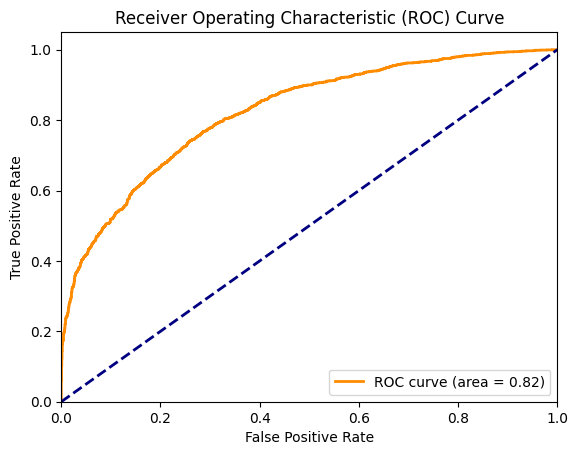

F1 Score: 0.7483977672110812
Precision: 0.6379978850898836
Recall (Sensitivity): 0.905


In [30]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


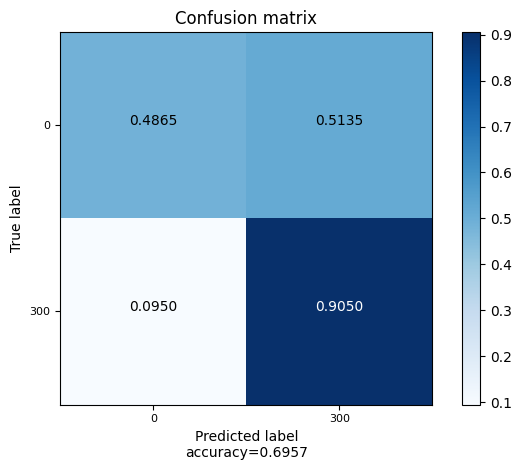

0

In [31]:
# Make predictions on the test data using the trained model and store the results in net_LCT
net_LCT.predict(gene_sim_test, model)

# Plot the confusion matrix of the predictions against the true classes, with text labels for clarity
net_LCT.plot_cm(gene_sim_test.classes, text=True)


In [32]:
path = './'
filename = 'AS_transfer_learning_vgg16.keras'

# Save the trained model to a file using the recommended Keras format
model.save(path + filename)